## Forecasting Exchange Rate Between US Dollars to Chinese Yuan with Machine Learning


In [ ]:
import pandas as pd
import numpy as np
import sklearn
from matplotlib import pyplot
import matplotlib.pyplot as plt
from datetime import timedelta

##Preprocessing 

In [ ]:
df = pd.read_csv('exchange-rate.csv')
#change the columns name "date" to "ds", "rate" to "y" in order to meeting the need of Prophet
df = df.rename({'date': 'ds', 'rate': 'y'}, axis=1)
df['ds'] = pd.to_datetime(df['ds'])

In [ ]:
# find the possilbe null value
df[df.isnull().T.any()]
# there is no null data

,ds,y


In [ ]:
# Split into training, validation and test datasets.
# Since it's timeseries we should do it by date.
test_cutoff_date = df['ds'].max() - timedelta(days=60)
val_cutoff_date = test_cutoff_date - timedelta(days=365)

df_test = df[df['ds'] > test_cutoff_date]
df_val = df[(df['ds'] > val_cutoff_date) & (df['ds'] <= test_cutoff_date)]
df_train = df[df['ds'] <= val_cutoff_date]

#check out the datasets
print('Test dates: {} to {}'.format(df_test['ds'].min(), df_test['ds'].max()))
print('Validation dates: {} to {}'.format(df_val['ds'].min(), df_val['ds'].max()))
print('Train dates: {} to {}'.format(df_train['ds'].min(), df_train['ds'].max()))



Test dates: 2021-08-03 00:00:00 to 2021-10-01 00:00:00
Validation dates: 2020-08-03 00:00:00 to 2021-08-02 00:00:00
Train dates: 1981-01-02 00:00:00 to 2020-08-01 00:00:00


## Prophet prediction

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



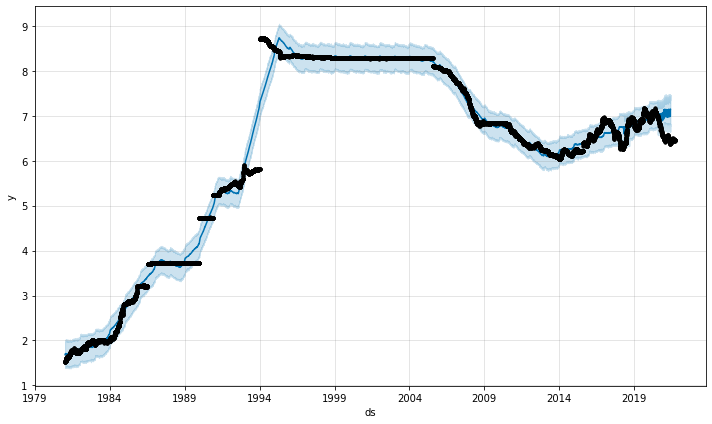

In [ ]:
from fbprophet import Prophet
def Prophet_Prediction(df_train):
  prophet_model = Prophet()
  prophet_model.fit(df_train)
  prophet_future = prophet_model.make_future_dataframe(periods=312)
  # get the prophet predict data
  prophet_predict = prophet_model.predict(prophet_future)
  #  plot to show 
  fig = prophet_model.plot(prophet_predict)
  ax = fig.add_subplot(111)
  ax.plot(df['ds'].astype('datetime64'), df['y'], 'k.')
  return prophet_predict
prophet_predict = Prophet_Prediction(df_train)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
mae = mean_absolute_error(df_val['y'].values, prophet_predict['yhat'][df_train.shape[0]:])
mape = mean_absolute_percentage_error(df_val['y'].values, prophet_predict['yhat'][df_train.shape[0]:])
rmse = np.sqrt(mean_squared_error(df_val['y'].values, prophet_predict['yhat'][df_train.shape[0]:]))

madianae = median_absolute_error (df_val['y'].values, prophet_predict['yhat'][df_train.shape[0]:])
Prophet_yhat = prophet_predict['yhat'][df_train.shape[0]:]
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)
print('Test Madian_Absolute_Error: %.3f' % madianae)


Test RMSE: 0.534
Test MAPE: 0.076
Test MAE: 0.496
Test Madian_Absolute_Error: 0.562


## xgboost

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



>expected=6.7909, predicted=6.7974
>expected=6.7909, predicted=6.8029
>expected=6.7908, predicted=6.7955
>expected=6.7908, predicted=6.7921
>expected=6.7906, predicted=6.7931
>expected=6.7902, predicted=6.7946
>expected=6.6947, predicted=6.7948
>expected=6.6947, predicted=6.6992
>expected=6.7460, predicted=6.6955
>expected=6.7465, predicted=6.7485
>expected=6.7151, predicted=6.7479
>expected=6.7254, predicted=6.7073
>expected=6.6976, predicted=6.7245
>expected=6.6976, predicted=6.7123
>expected=6.6822, predicted=6.7026
>expected=6.6767, predicted=6.6896
>expected=6.6511, predicted=6.6673
>expected=6.6846, predicted=6.6431
>expected=6.6868, predicted=6.6784
>expected=6.6868, predicted=6.6989
>expected=6.7122, predicted=6.6819
>expected=6.7055, predicted=6.7209
>expected=6.7290, predicted=6.7069
>expected=6.7150, predicted=6.7227
>expected=6.6912, predicted=6.7217
>expected=6.6912, predicted=6.7013
>expected=6.6912, predicted=6.6969
>expected=6.6777, predicted=6.6780
>expected=6.6535, pr

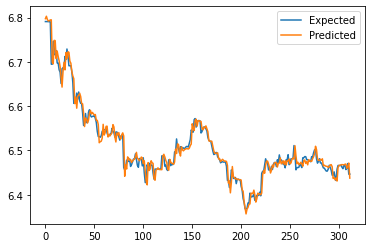

In [ ]:
# forecast monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot
 
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]
 
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	xgboost_yhat = model.predict(asarray([testX]))
	return xgboost_yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		xgboost_yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(xgboost_yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.4f, predicted=%.4f' % (testy, xgboost_yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions
 
# load the dataset
series = read_csv('exchange-rate.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, xgboost_yhat = walk_forward_validation(data, 312)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(xgboost_yhat, label='Predicted')
pyplot.legend()


In [ ]:
'''
rmse = np.sqrt(mean_squared_error(df_val['y'].values, xgboost_yhat))
print('Test RMSE: %.3f' % rmse)
'''
mae = mean_absolute_error(df_val['y'].values, xgboost_yhat)
mape = mean_absolute_percentage_error(df_val['y'].values, xgboost_yhat)
rmse = np.sqrt(mean_squared_error(df_val['y'].values, xgboost_yhat))
madianae = median_absolute_error (df_val['y'].values, xgboost_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)
print('Test Madian_Absolute_Error: %.3f' % madianae)

Test RMSE: 0.122
Test MAPE: 0.015
Test MAE: 0.099
Test Madian_Absolute_Error: 0.081


## Arima

In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 15.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


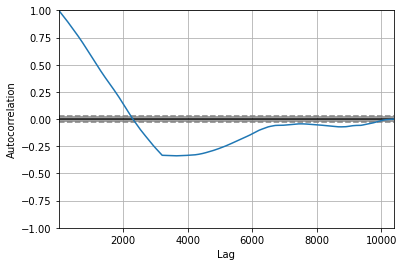

In [ ]:
from pandas.plotting import autocorrelation_plot
def autocorrelation_Arima(df):
  df["ds"] = df["ds"].astype("datetime64")
  df = df.set_index("ds")
  #plt.title('Auto_Arima Autocorrelation')
  autocorrelation_plot(df)
  pyplot.show()
autocorrelation_Arima(df)

In [ ]:
def arima_Prediction(df_train, df_val):
  from pmdarima.arima import auto_arima
  df_train.drop("ds", axis = 1, inplace = True)
  df_val.drop("ds", axis = 1, inplace = True)
  model = auto_arima(df_train, trace = True, error_action = "ignore", suppress_warnings= True)
  model.fit(df_train)
  forecast = model.predict(n_periods=len(df_val),exog = None)
  forecast = pd.DataFrame(forecast, index = df_val.index, columns = ['Prediction'])
  return forecast
Arima_yhat = arima_Prediction(df_train,df_val)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=7.72 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-33110.352, Time=0.80 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-36022.093, Time=0.31 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=3.28 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-37195.817, Time=0.73 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-37845.647, Time=0.66 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=-38265.680, Time=5.64 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=-38541.861, Time=2.00 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=11.42 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=9.34 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-38539.861, Time=26.75 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 68.687 seconds


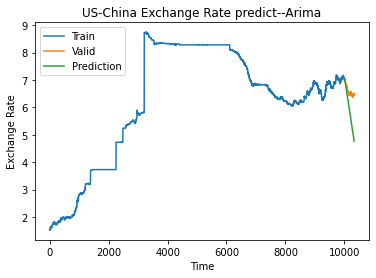

In [ ]:
from matplotlib import pyplot as plt
plt.plot(df_train, label = "Train")
plt.plot(df_val, label = "Valid")
plt.plot(Arima_yhat,label = "Prediction")
plt.title('US-China Exchange Rate predict--Arima')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [ ]:
'''
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(df_val, Arima_yhat))
print('Test RMSE: %.3f' % rmse)
'''

mae = mean_absolute_error(df_val['y'].values, Arima_yhat)
mape = mean_absolute_percentage_error(df_val['y'].values, Arima_yhat)
rmse = np.sqrt(mean_squared_error(df_val['y'].values, Arima_yhat))
madianae = median_absolute_error (df_val['y'].values, Arima_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)
print('Test Madian_Absolute_Error: %.3f' % madianae)

Test RMSE: 0.871
Test MAPE: 0.109
Test MAE: 0.705
Test Madian_Absolute_Error: 0.594


## LSTM with RNN

In [ ]:
import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import * 
from sklearn .preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import train_test_split 
from keras.callbacks import EarlyStopping

def LSTM_RNN_Prediction(df_train,df_val):
  df_train_2 = df_train.iloc[:,1:2].values
  X_train = []
  y_train = []
  for i in range(30,df_train_2.shape[0]):
    X_train.append(df_train_2[i-30:i,0])
    y_train.append(df_train_2[i,0])
  X_train, y_train = np.array(X_train), np.array(y_train)
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

  # initialize our RNN
  regressor = Sequential()

  regressor.add(LSTM(units = 50, return_sequences = True,input_shape = (X_train.shape[1], 1)))
  regressor.add(Dropout(0.2))

  regressor.add(LSTM(units = 50, return_sequences = True))
  regressor.add(Dropout(0.2))

  regressor.add(LSTM(units = 50, return_sequences = True))
  regressor.add(Dropout(0.2))

  regressor.add(LSTM(units = 50))
  regressor.add(Dropout(0.2))

  regressor.add(Dense(units = 1))

  regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

  regressor.fit(X_train, y_train, epochs = 10, batch_size = 100)
  df_val_2 = df_val.iloc[:,1:2].values

  X_test = []
  for i in range(30, df_val_2.shape[0]):
    X_test.append(df_val_2[i-30:i, 0])
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  predicted_rate = regressor.predict(X_test)
  return predicted_rate, df_val_2
LSTM_yhat,df_val_2 = LSTM_RNN_Prediction(df_train,df_val)

Epoch 1/10
100/100 [==============================] - 18s 104ms/step - loss: 7.0494
Epoch 2/10
100/100 [==============================] - 10s 104ms/step - loss: 0.4512
Epoch 3/10
100/100 [==============================] - 10s 104ms/step - loss: 0.3441
Epoch 4/10
100/100 [==============================] - 10s 104ms/step - loss: 0.3169
Epoch 5/10
100/100 [==============================] - 10s 104ms/step - loss: 0.2957
Epoch 6/10
100/100 [==============================] - 10s 103ms/step - loss: 0.2832
Epoch 7/10
100/100 [==============================] - 10s 104ms/step - loss: 0.2754
Epoch 8/10
100/100 [==============================] - 10s 104ms/step - loss: 0.2662
Epoch 9/10
100/100 [==============================] - 10s 104ms/step - loss: 0.2566
Epoch 10/10
100/100 [==============================] - 10s 103ms/step - loss: 0.2646


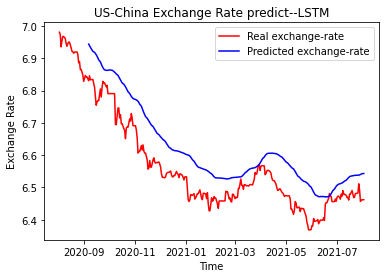

In [ ]:
# Visualising the results
plt.plot(df_val['ds'],df_val['y'], color = 'red', label = 'Real exchange-rate')
plt.plot(df_val[30:312]['ds'],LSTM_yhat, color = 'blue', label = 'Predicted exchange-rate')
#plt.xticks(np.arange(0,459,50))
plt.title('US-China Exchange Rate predict--LSTM')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [ ]:
'''
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(df_val_2[30:312, 0], LSTM_yhat))
print('Test RMSE: %.3f' % rmse)
'''
mae = mean_absolute_error(df_val_2[30:312, 0], LSTM_yhat)
mape = mean_absolute_percentage_error(df_val_2[30:312, 0], LSTM_yhat)
rmse = np.sqrt(mean_squared_error(df_val_2[30:312, 0], LSTM_yhat))
madianae = median_absolute_error (df_val_2[30:312, 0], LSTM_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)
print('Test Madian_Absolute_Error: %.3f' % madianae)

Test RMSE: 0.087
Test MAPE: 0.012
Test MAE: 0.080
Test Madian_Absolute_Error: 0.080


# Use linear regression to calculate the weight

In [ ]:
Prophet_yhat2 = np.array(Prophet_yhat)
Prophet_yhat3 = Prophet_yhat2.reshape(-1,1)

In [ ]:
Arima_yhat2 = Arima_yhat.to_numpy()
Arima_yhat3 = Arima_yhat2.reshape(-1,1)

In [ ]:
k = np.hstack((Prophet_yhat3, Arima_yhat3))
k.shape

(312, 2)

In [ ]:
xgboost_yhat2 = np.array(xgboost_yhat)
xgboost_yhat3 = xgboost_yhat2.reshape(-1,1)
m = np.hstack((k,xgboost_yhat3))

In [ ]:
LSTM_yhat.shape

(282, 1)

In [ ]:
LSTM_yhat33 = df_val['y'][0:30].to_numpy()
LSTM_yhat34 = LSTM_yhat33.reshape(-1,1)

In [ ]:
LSTM_yhat2 = np.vstack((LSTM_yhat34, LSTM_yhat))
LSTM_yhat2.shape

(312, 1)

In [ ]:
Xdata1 = np.hstack((m,LSTM_yhat2))
ydata = df_val['y'].to_numpy().reshape(-1,1)
ones = np.ones(312).reshape(-1,1)
Xdata = np.hstack((Xdata1, ones))
Xdata.shape

(312, 5)

In [ ]:
# the loss function
'''
y_hat : 312*1 matrix
y: 312*1 matrix 
'''
def compute_loss (y_hat, y):
  loss = []
  for i in range (len(y_hat)):
    loss.append(y_hat[i] - y[i]) 
  return np.mean(loss)
# the gradient function 
'''
X: 312*5 matrix
y_hat : 312*1 matrix
y: 312*1 matrix 
'''
def compute_gradient (X, y, y_hat):

  gradient = np.dot((y_hat - y).T, X)
  return gradient/70000
# Check if the algorithm has converged.
def hasConverged(epsilon, thetaOld, thetaNew):
  l2_sum = 0
  for i in range(len(thetaOld)):
    l2_sum = np.sqrt((thetaNew[i] - thetaOld[i]**2)) + l2_sum
  if ( l2_sum < epsilon):
    return True
  else:
    return False
# fit the data for once
'''
X: 312*5 matrix
y: 312*1 matrix 
theta: 1*5 matrix
alpha: int
'''
def fitonce (theta, X, y,alpha):
  L = compute_loss(np.dot(X,theta.T),y)
  gradient = compute_gradient(X,y,np.dot(X, theta.T))
  theta_new = theta - alpha*gradient

  return L, theta_new 
# fit the best 
'''
X: 312*5 matrix
y: 312*1 matrix 
'''
def fit (X, y):
  alpha = 0.95
  N_inter = 2
  epsilon = 0.1
  iter = 0
  #theta_old = np.array([0.25,0.25,0.25,0.25,1])
  theta_old = np.array([0.25,0.25,3.3])
  theta_new = fitonce(theta_old, X, y, alpha)[1]
  

  while hasConverged(epsilon, theta_old,theta_new) == False and iter < N_inter -1 :
     theta_old = theta_new
     theta_new = fitonce(theta_old,X,y,alpha)[1]
     iter += 1
  return theta_new

# predict 
def predict (theta, X):

  return np.dot(X, theta.T)

In [ ]:
theta = fit(Xdata, y)

In [ ]:
print(theta)

[0.21144307 0.21726305 0.21441487 0.21356694 0.99454085]


In [ ]:
from sklearn.linear_model import LinearRegression
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(Xdata,ydata)

print(LR.coef_)

[[ 0.07644344 -0.01966347  0.28446975  0.99237812  0.        ]]


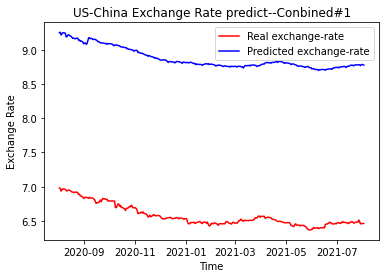

In [ ]:
y_after = np.dot(Xdata,LR.coef_.T )
plt.plot(df_val['ds'],df_val['y'], color = 'red', label = 'Real exchange-rate')
plt.plot(df_val['ds'],y_after, color = 'blue', label = 'Predicted exchange-rate')
plt.title('US-China Exchange Rate predict--Conbined#1')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [ ]:


mae = mean_absolute_error(df_val['y'].values, y_after)
mape = mean_absolute_percentage_error(df_val['y'].values, y_after)
rmse = np.sqrt(mean_squared_error(df_val['y'].values, y_after))
madianae = median_absolute_error (df_val['y'].values, y_after)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)
print('Test Madian_Absolute_Error: %.3f' % madianae)


Test RMSE: 2.299
Test MAPE: 0.350
Test MAE: 2.299
Test Madian_Absolute_Error: 2.298


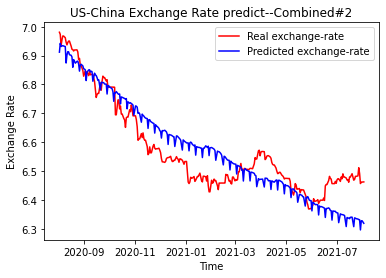

In [ ]:
y_after2 = np.dot(Xdata,theta.T )
plt.plot(df_val['ds'],df_val['y'], color = 'red', label = 'Real exchange-rate')
plt.plot(df_val['ds'],y_after2, color = 'blue', label = 'Predicted exchange-rate')
plt.title('US-China Exchange Rate predict--Combined#2')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [ ]:

mae = mean_absolute_error(df_val['y'].values, y_after2)
mape = mean_absolute_percentage_error(df_val['y'].values, y_after2)
rmse = np.sqrt(mean_squared_error(df_val['y'].values, y_after2))
madianae = median_absolute_error (df_val['y'].values, y_after2)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)
print('Test Madian_Absolute_Error: %.3f' % madianae)

Test RMSE: 0.077
Test MAPE: 0.010
Test MAE: 0.063
Test Madian_Absolute_Error: 0.059


# Only LSTM and xgboost

In [ ]:
Xdata_Lxg =  np.hstack((LSTM_yhat2,xgboost_yhat3))
ones = np.ones(312).reshape(-1,1)
Xdata_Lxg = np.hstack((Xdata_Lxg, ones))
Xdata_Lxg.shape

(312, 3)

In [ ]:
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(Xdata_Lxg,ydata)
print(LR.coef_)

[[0.89890373 0.2794011  0.        ]]


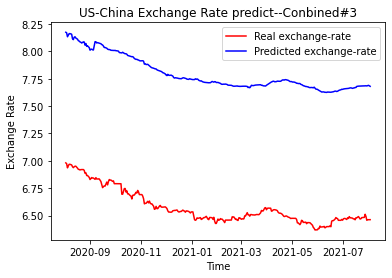

In [ ]:
y_after3 = np.dot(Xdata_Lxg,LR.coef_.T )
plt.plot(df_val['ds'],df_val['y'], color = 'red', label = 'Real exchange-rate')
plt.plot(df_val['ds'],y_after3, color = 'blue', label = 'Predicted exchange-rate')
plt.title('US-China Exchange Rate predict--Conbined#3')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [ ]:

mae = mean_absolute_error(df_val['y'].values, y_after3)
mape = mean_absolute_percentage_error(df_val['y'].values, y_after3)
rmse = np.sqrt(mean_squared_error(df_val['y'].values, y_after3))
madianae = median_absolute_error (df_val['y'].values, y_after3)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)
print('Test Madian_Absolute_Error: %.3f' % madianae)

Test RMSE: 1.220
Test MAPE: 0.186
Test MAE: 1.219
Test Madian_Absolute_Error: 1.222


In [ ]:
theta_Lxg = fit(Xdata_Lxg, y)
print(theta_Lxg)

[0.2462953  0.24638495 3.29944096]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning:

invalid value encountered in sqrt



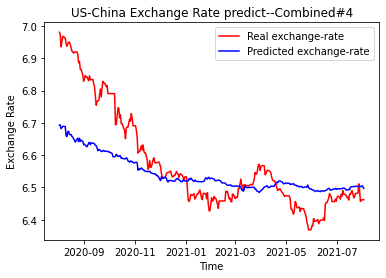

In [ ]:
y_after4 = np.dot(Xdata_Lxg,theta_Lxg.T )
plt.plot(df_val['ds'],df_val['y'], color = 'red', label = 'Real exchange-rate')
plt.plot(df_val['ds'],y_after4, color = 'blue', label = 'Predicted exchange-rate')
plt.title('US-China Exchange Rate predict--Combined#4')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [ ]:

mae = mean_absolute_error(df_val['y'].values, y_after4)
mape = mean_absolute_percentage_error(df_val['y'].values, y_after4)
rmse = np.sqrt(mean_squared_error(df_val['y'].values, y_after4))
madianae = median_absolute_error (df_val['y'].values, y_after4)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)
print('Test Madian_Absolute_Error: %.3f' % madianae)

Test RMSE: 0.111
Test MAPE: 0.012
Test MAE: 0.081
Test Madian_Absolute_Error: 0.052
